# Sentiment Analysis with BERT

State-of-the-art sentiment analysis typically doesn’t rely on bag-of-words models. Instead, it uses BERT models fine-tuned on sentiment-analysis datasets. Fine-tuning is accomplished by further training a pretrained model for a limited number of epochs and with a reduced learning rate. Let’s fine-tune BERT and see if we can create a sentiment-analysis model that’s more accurate than a bag-of-words model. If your computer isn’t equipped with a GPU, consider running this example in [Google Colab](https://colab.research.google.com/). Even on GPU, it can take an hour or so to run – depending on the type of GPU, of course.

If you're doing this exercise in Colab, start by using the following commands to install Hugging Face's [`transformers`](https://pypi.org/project/transformers/) and [`datasets`](https://pypi.org/project/datasets/) packages. If you're running the code locally, you can skip this step provided the packages are already installed.

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Next, load the IMDB dataset from the `datasets` package.:

In [2]:
from datasets import load_dataset

imdb = load_dataset('imdb')
imdb

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Create a tokenizer that tokenizes input text using the [WordPiece](https://huggingface.co/course/chapter6/6?fw=pt) format that BERT expects:

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(samples):
    return tokenizer(samples['text'], truncation=True)

tokenized_imdb = imdb.map(tokenize, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-9fa7c0afdd99f740.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-cc78e04a4aeed0cb.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-7e73df467655263f.arrow


Now that the reviews are tokenized, they need to be converted from [Hugging Face datasets](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset) into [TensorFlow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) with Hugging Face’s [Dataset.to_tf_dataset](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.to_tf_dataset) method. The collating function passed to that method dynamically pads the sequences so they’re all the same length. You can also ask the tokenizer to do the padding, but padding performed that way is static and requires more memory:

In [4]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

train_data = tokenized_imdb['train'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'label'],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator
)

validation_data = tokenized_imdb['test'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'label'],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator
)

Now you’re ready to fine-tune. Call `fit` on the model as usual, but set the `Adam` optimizer’s learning rate (the nominal amount that weights and biases are adjusted during backpropagation passes) to 0.00002, which is a fraction of the default learning rate of 0.001:

In [5]:
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.compile(Adam(learning_rate=2e-5), metrics=['accuracy'])
hist = model.fit(train_data, validation_data=validation_data, epochs=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/3
1563/1563 [==============================] - 1166s 737ms/step - loss: 0.2510 - accuracy: 0.8985 - val_loss: 0.1943 - val_accuracy: 0.9237
Epoch 2/3
1563/1563 [==============================] - 1150s 736ms/step - loss: 0.1339 - accuracy: 0.9520 - val_loss: 0.2034 - val_accuracy: 0.9322
Epoch 3/3
1563/1563 [==============================] - 1148s 735ms/step - loss: 0.0706 - accuracy: 0.9765 - val_loss: 0.2438 - val_accuracy: 0.9241


Plot the training and validation accuracy to see where the latter topped out:

[]

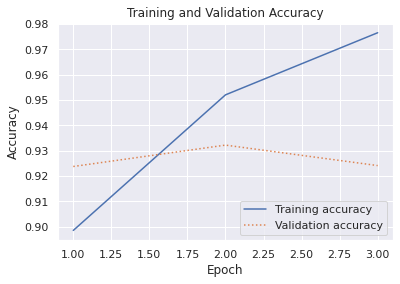

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Finish up by defining an `analyze_text` function that returns a sentiment score and using it to score a positive review for sentiment. The model returns an object wrapping a tensor containing unnormalized sentiment scores (negative and positive), but you can use TensorFlow’s `softmax` function to normalize them to values from 0.0 to 1.0:

In [7]:
import tensorflow as tf

def analyze_text(text, tokenizer, model):
    tokenized_text = tokenizer(text, padding=True, truncation=True, return_tensors='tf')
    prediction = model(tokenized_text)
    return tf.nn.softmax(prediction[0]).numpy()[0][1]

analyze_text('Great food and excellent service!', tokenizer, model)

0.9942516

Try it again with a negative review:

In [8]:
analyze_text('The long lines and poor customer service really turned me off.', tokenizer, model)

0.05750778

Fine-tuning isn’t cheap, but it isn’t nearly as expensive as training a sophisticated transformer from scratch. The fact that you could train a sentiment-analysis model to be this accurate in an hour or less of GPU time is a tribute to the power of pretrained BERT models, and to the Google engineers who trained them.